In [64]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import os
import math
from helper_functions import filter_bold
#from mne.time_frequency import psd_array_multitaper


def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - params["wsize"] - 1, params["wsize"] - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + params["wsize"] + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
params = dmf.default_params(C=C)
RECEPTORS = np.load("./data/Schaeffer200-Tian/5HT2a_cimbi_hc29_beliveau_schaeffer200.npy")[:200]
RECEPTORS = RECEPTORS/max(RECEPTORS)-min(RECEPTORS)
RECEPTORS = RECEPTORS - max(RECEPTORS) + 1
params["receptors"] = RECEPTORS
# Main setup for this simulation
params["return_rate"] = True
params["return_bold"] = True
params["return_fic"] = True
# These are now default true
params["with_plasticity"] = True
params["with_decay"] = True

isubfcd = np.triu_indices(C.shape[1],1)
burnout = 7
params["flp"] = 0.01
params["fhp"] = 0.1
params["wsize"] = 30
overlap = 29
#nb_steps = 460000
#T = (nb_steps/params["TR"])*params["dtt"]
T = 250
params['TR'] = 2
nb_steps = int((T*params["TR"])/params["dtt"])
win_start = np.arange(0, T - burnout - params["wsize"], params["wsize"] - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])
b_filter,a_filter = butter(2,np.array([0.01, 0.1])*2*params['TR'], btype='band')

# Load coefficients to estimte Decay with LR

fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
triu_idx = np.triu_indices(C.shape[1],1)
params['N'] = C.shape[0]

#GAINE_range = np.arange(0,1,0.01)
#LR_range = np.logspace(0,2.46,10)

GAINE_range = np.arange(0.4,0.81,0.01)
LR_range = [1]

# Define the number of cores to use
NUM_CORES = 16

mean_fc_grid = np.zeros((len(LR_range),len(GAINE_range),params['N'],params['N']))
sim_fcds_grid = np.zeros((len(LR_range),len(GAINE_range),nwins-1,nwins-1))
mean_fr_grid = np.zeros((len(LR_range),len(GAINE_range), params['N']))
std_fr_grid = np.zeros((len(LR_range),len(GAINE_range), params['N']))


G = 2.21
#LR = 44.3
def grid_step(args):
    LR_tuple,GAINE_tuple = args
    idx_GAINE,GAINE = GAINE_tuple[0],GAINE_tuple[1]    
    idx_LR,LR = LR_tuple[0],LR_tuple[1]    
    params['G'] = G
    params['lrj'] = LR
    try:
        DECAY = np.exp(a + np.log(LR) * b)
    except RuntimeWarning:
        print(f"RuntimeWarning: DECAY = {DECAY}, LR = {LR}")
    OBJ_RATE = 3.44    
    params['wgaine'] = GAINE
    params['wgaini'] = GAINE
    # Using heuristic linear rule 
    params['taoj'] = DECAY 
    params['obj_rate'] = OBJ_RATE
    #params['taoj'] = 210000

    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1    
    rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps)     
    bold = bold[:, burnout:]
    if not (np.isnan(rates).any() or np.isinf(rates).any() or
            np.isnan(bold).any() or np.isinf(bold).any() or
            np.isnan(fic_t).any() or np.isinf(fic_t).any()):
        filt_bold = filter_bold(bold.T, params['flp'], params['fhp'], params['TR'])
        time_fc = compute_fcd(filt_bold, params["wsize"], overlap, isubfcd)
        bold_fc = np.corrcoef(filt_bold.T)
        fcd = np.corrcoef(time_fc.T)
        mean_firing_rates = np.mean(rates, axis=1)
        std_firing_rates = np.std(rates, axis=1)
        return idx_LR,idx_GAINE, bold_fc, fcd,mean_firing_rates, std_firing_rates
    else:
        return None, None, rates,bold,fic_t



In [67]:
args_list = [((idx_LR,LR),(idx_GAINE,GAINE))             
             for idx_GAINE,GAINE in enumerate(GAINE_range)
             for idx_LR, LR in enumerate(LR_range)]

for args in args_list:
    res = grid_step(args)
    #idx_LR,idx_GAINE, bold_fc, fcd,mean_firing_rates, std_firing_rates = grid_step(args)
    if res[0] is not None:
        # Unpack results
        idx_LR,idx_GAINE, bold_fc, fcd,mean_firing_rates, std_firing_rates = res
        mean_fc_grid[idx_LR,idx_GAINE] = bold_fc
        sim_fcds_grid[idx_LR,idx_GAINE] = fcd
        mean_fr_grid[idx_LR,idx_GAINE] = mean_firing_rates
        std_fr_grid[idx_LR,idx_GAINE] = std_firing_rates
    else:
        # If tmp folder not create it
        if os.path.isdir("./tmp") is False:
            os.mkdir("./tmp")
        # Save the results in a tmp file        
        np.save(f"./tmp/tmp_{args}", res)
        break

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [88]:
idx_LR, idx_GAINE, rates,bold,fic_t = res

In [71]:
# Check inf and nan values
if (np.isnan(rates).any() or np.isinf(rates).any() or
    np.isnan(bold).any() or np.isinf(bold).any() or
    np.isnan(fic_t).any() or np.isinf(fic_t).any()):
    print("There are inf or nan values in the results")

There are inf or nan values in the results


In [78]:
# Check inf and nan values
if (np.isnan(bold).any()):
    print("There are inf or nan values in the results")

There are inf or nan values in the results


In [90]:
# For each region count the amount of nans
nans = np.sum(np.isnan(bold), axis=1)
# extract the region that has the most nans
region = np.argmax(nans)


In [91]:
nans

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

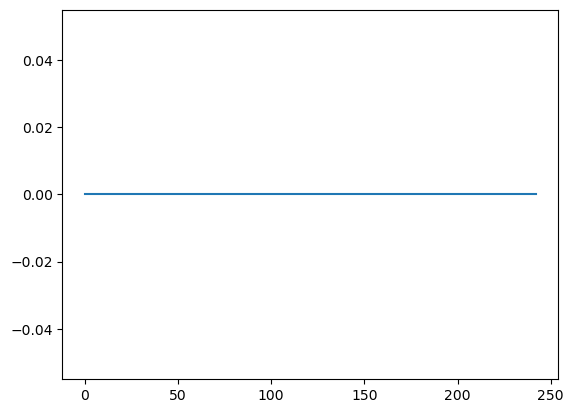

In [ ]:
# Plot the bold of the region replcaing nan with 0
bold[region] = np.nan_to_num(bold[region], nan=0.0)
plt.plot(bold[region])
plt.show()


In [58]:

from multiprocessing import Pool,Manager


# Define the number of cores to use
#LR_range = np.arange(0,1,0.01)[:2]
# Create a list of argument tuples for the nested loop function
args_list = [((idx_LR,LR),(idx_GAINE,GAINE))             
             for idx_GAINE,GAINE in enumerate(GAINE_range)
             for idx_LR, LR in enumerate(LR_range)]

In [59]:

manager = Manager()
results_list = manager.list()
# Create a pool of worker processes
with Pool(processes=NUM_CORES) as pool:
    # Map the nested loop function to the argument list across multiple processes
    results_list.extend(pool.map(grid_step, args_list))

In [60]:



#return idx_GAINE, mean_fc, sim_fcds,mean_firing_rates, std_firing_rates
for results in results_list:
    idx_LR = results[0]
    idx_GAINE = results[1]        
    mean_fc = results[2]
    sim_fcds = results[3] 
    mean_fr = results[4]  
    std_fr = results[5]
    
    mean_fc_grid[idx_LR,idx_GAINE] = mean_fc
    sim_fcds_grid[idx_LR,idx_GAINE] = sim_fcds
    mean_fr_grid[idx_LR,idx_GAINE] = mean_fr
    std_fr_grid[idx_LR,idx_GAINE] = std_fr



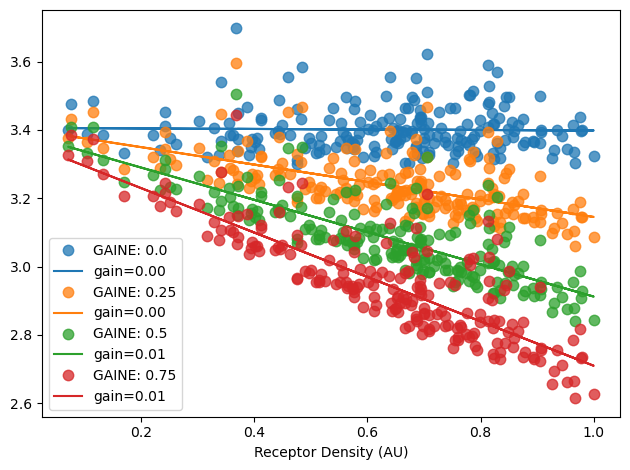

In [62]:
# For a fixed LR scatter plot the average firing rate vs receptor density
plt.figure()
for idx_GAINE,g in enumerate(GAINE_range):
    plot, = plt.plot(RECEPTORS,mean_fr_grid[1,idx_GAINE],'.', markersize=15, alpha=0.75,label=f"GAINE: {g}")
    coeffs = np.polyfit(np.squeeze(RECEPTORS), mean_fr_grid[1,idx_GAINE], 1)
    linear_fit = np.poly1d(coeffs)        
    # Plot the linear fit
    plt.plot(RECEPTORS, linear_fit(RECEPTORS), '-', color=plot.get_color(),
                label=f'gain={g/100:.2f}')
    
    plt.xlabel('Receptor Density (AU)')                
    

    plt.legend()    
plt.tight_layout()

plt.show()

In [ ]:

import os

# Assuming these arrays are already populated with data

arrays_to_save = {
    'mean_fc_grid': mean_fc_grid,
    'sim_stds_grid': sim_fcds_grid,
    'mean_fr_grid': mean_fr_grid,
    'std_fr_grid': std_fr_grid
    
}


results_folder = "./Results/neuromod/dynamic5HT2a"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)


# Save
for array_name, array_data in arrays_to_save.items():
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    np.save(file_name, array_data)


In [51]:
# Iterate over all receptors in data/Schafer200-Tian
for fname in os.listdir('./data/Schaeffer200-Tian/'):
    print(fname)
    RECEPTORS = np.load(f'./data/Schaeffer200-Tian/{fname}')
    RECEPTORS = RECEPTORS[:200]
    RECEPTORS = RECEPTORS/max(RECEPTORS)-min(RECEPTORS)
    RECEPTORS = RECEPTORS - max(RECEPTORS) + 1
    # Plot histogram without showing and save it in Plots
    plt.hist(RECEPTORS, bins=100, density=True)
    plt.savefig(f'Figures/Schaefer200-Tian/{fname}.png')
    plt.close()


FDOPA_fluorodopa_hc12_gomez_schaeffer200.npy
5HT2a_alt_hc19_savli_schaeffer200.npy
A4B2_flubatine_hc30_hillmer_schaeffer200.npy
5HT6_gsk_hc30_radhakrishnan_schaeffer200.npy
VAChT_feobv_hc18_aghourian_sum_schaeffer200.npy
VAChT_feobv_hc5_bedard_sum_schaeffer200.npy
MU_carfentanil_hc39_turtonen_schaeffer200.npy
NAT_MRB_hc10_hesse_schaeffer200.npy
NAT_MRB_hc77_ding_schaeffer200.npy
MU_carfentanil_hc204_kantonen_schaeffer200.npy
5HTT_dasb_hc100_beliveau_schaeffer200.npy
mGluR5_abp_hc22_rosaneto_schaeffer200.npy
D1_SCH23390_hc13_kaller_schaeffer200.npy
D2_flb457_hc55_sandiego_schaeffer200.npy
D2_raclopride_hc7_alakurtti_schaeffer200.npy
mGluR5_abp_hc73_smart_schaeffer200.npy
5HTT_dasb_hc30_savli_schaeffer200.npy
5HT2a_mdl_hc3_talbot_schaeffer200.npy
5HT4_sb20_hc59_beliveau_schaeffer200.npy
H3_cban_hc8_gallezot_schaeffer200.npy
5HT1a_cumi_hc8_beliveau_schaeffer200.npy
DAT_fpcit_hc174_dukart_spect_schaeffer200.npy
M1_lsn_hc24_naganawa_schaeffer200.npy
DAT_fepe2i_hc6_sasaki_schaeffer200.npy
mG